(379, 600)


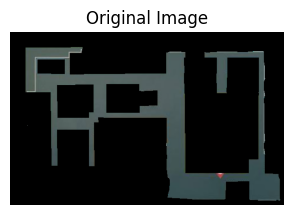

(379, 600)


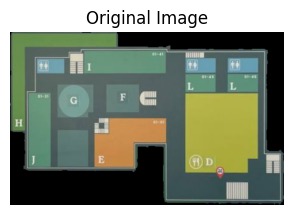

[{'x': 232, 'y': 32}, {'x': 33, 'y': 33}, {'x': 33, 'y': 215}, {'x': 6, 'y': 216}, {'x': 5, 'y': 4}, {'x': 234, 'y': 5}]
1
[{'x': 119, 'y': 91}, {'x': 119, 'y': 60}, {'x': 60, 'y': 60}, {'x': 60, 'y': 90}]
2
[{'x': 39, 'y': 132}, {'x': 88, 'y': 132}, {'x': 90, 'y': 295}, {'x': 40, 'y': 295}]
1
[{'x': 160, 'y': 46}, {'x': 131, 'y': 46}, {'x': 131, 'y': 92}, {'x': 161, 'y': 92}]
3
[{'x': 103, 'y': 214}, {'x': 172, 'y': 214}, {'x': 172, 'y': 294}, {'x': 104, 'y': 294}]
1
[{'x': 182, 'y': 115}, {'x': 182, 'y': 175}, {'x': 172, 'y': 175}, {'x': 172, 'y': 187}, {'x': 104, 'y': 187}, {'x': 103, 'y': 116}]
1
[{'x': 211, 'y': 114}, {'x': 282, 'y': 114}, {'x': 283, 'y': 176}, {'x': 211, 'y': 176}]
1
[{'x': 162, 'y': 42}, {'x': 341, 'y': 42}, {'x': 341, 'y': 90}, {'x': 162, 'y': 91}]
1
[{'x': 322, 'y': 128}, {'x': 322, 'y': 160}, {'x': 284, 'y': 161}, {'x': 284, 'y': 130}]
3
[{'x': 342, 'y': 188}, {'x': 342, 'y': 242}, {'x': 272, 'y': 243}, {'x': 272, 'y': 294}, {'x': 185, 'y': 295}, {'x': 184, '

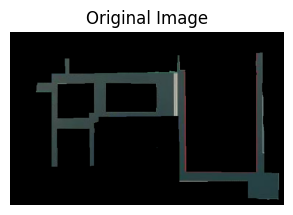

(379, 600)


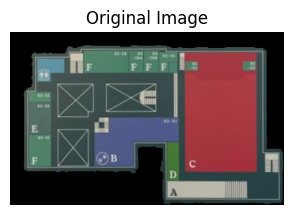

[{'x': 520, 'y': 327}, {'x': 344, 'y': 328}, {'x': 344, 'y': 364}, {'x': 520, 'y': 364}]
3
[{'x': 557, 'y': 307}, {'x': 588, 'y': 308}, {'x': 588, 'y': 266}, {'x': 557, 'y': 266}]
3
[{'x': 370, 'y': 240}, {'x': 343, 'y': 240}, {'x': 343, 'y': 326}, {'x': 370, 'y': 325}]
1
[{'x': 368, 'y': 184}, {'x': 216, 'y': 186}, {'x': 216, 'y': 221}, {'x': 184, 'y': 221}, {'x': 184, 'y': 294}, {'x': 272, 'y': 295}, {'x': 272, 'y': 241}, {'x': 369, 'y': 240}]
1
[{'x': 194, 'y': 196}, {'x': 194, 'y': 186}, {'x': 216, 'y': 186}, {'x': 216, 'y': 221}, {'x': 185, 'y': 221}, {'x': 184, 'y': 199}]
3
[{'x': 173, 'y': 212}, {'x': 103, 'y': 212}, {'x': 104, 'y': 294}, {'x': 174, 'y': 292}]
0
[{'x': 90, 'y': 225}, {'x': 40, 'y': 225}, {'x': 41, 'y': 295}, {'x': 90, 'y': 294}]
1
[{'x': 90, 'y': 224}, {'x': 42, 'y': 224}, {'x': 41, 'y': 153}, {'x': 90, 'y': 153}]
1
[{'x': 90, 'y': 153}, {'x': 90, 'y': 132}, {'x': 40, 'y': 132}, {'x': 41, 'y': 153}]
1
[{'x': 90, 'y': 110}, {'x': 90, 'y': 90}, {'x': 120, 'y': 90}

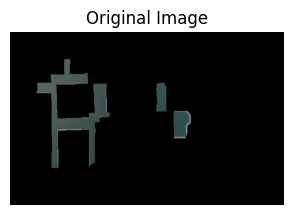

(379, 600)


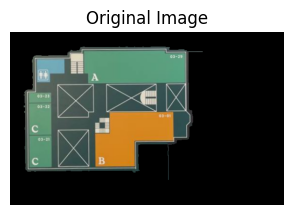

[{'x': 274, 'y': 294}, {'x': 274, 'y': 240}, {'x': 358, 'y': 239}, {'x': 357, 'y': 174}, {'x': 218, 'y': 176}, {'x': 218, 'y': 222}, {'x': 186, 'y': 222}, {'x': 186, 'y': 296}]
1
[{'x': 218, 'y': 186}, {'x': 217, 'y': 222}, {'x': 187, 'y': 222}, {'x': 186, 'y': 198}, {'x': 196, 'y': 198}, {'x': 196, 'y': 188}]
3
[{'x': 172, 'y': 214}, {'x': 172, 'y': 294}, {'x': 106, 'y': 294}, {'x': 105, 'y': 216}]
0
[{'x': 172, 'y': 186}, {'x': 172, 'y': 176}, {'x': 184, 'y': 176}, {'x': 182, 'y': 114}, {'x': 102, 'y': 115}, {'x': 104, 'y': 188}]
0
[{'x': 211, 'y': 114}, {'x': 321, 'y': 114}, {'x': 319, 'y': 127}, {'x': 284, 'y': 128}, {'x': 284, 'y': 158}, {'x': 320, 'y': 158}, {'x': 320, 'y': 173}, {'x': 212, 'y': 175}]
0
[{'x': 320, 'y': 126}, {'x': 283, 'y': 127}, {'x': 284, 'y': 158}, {'x': 321, 'y': 158}]
3
[{'x': 342, 'y': 112}, {'x': 385, 'y': 112}, {'x': 386, 'y': 172}, {'x': 342, 'y': 172}]
0
[{'x': 91, 'y': 226}, {'x': 39, 'y': 226}, {'x': 41, 'y': 297}, {'x': 90, 'y': 298}]
1
[{'x': 90, '

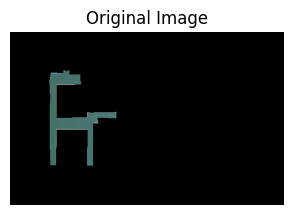

C:\Users\yongl\AppData\Local\Temp\ipykernel_22108\1690832339.py:36: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  pruned = remove_small_objects(labeled, min_size=200)  # adjust size to control pruning


(379, 600)


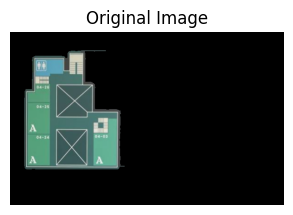

[{'x': 192, 'y': 188}, {'x': 214, 'y': 188}, {'x': 214, 'y': 220}, {'x': 182, 'y': 220}, {'x': 182, 'y': 200}, {'x': 194, 'y': 200}]
3
[{'x': 215, 'y': 189}, {'x': 234, 'y': 189}, {'x': 234, 'y': 294}, {'x': 182, 'y': 294}, {'x': 182, 'y': 221}, {'x': 213, 'y': 220}]
1
[{'x': 169, 'y': 214}, {'x': 102, 'y': 214}, {'x': 101, 'y': 292}, {'x': 168, 'y': 292}]
0
[{'x': 86, 'y': 224}, {'x': 38, 'y': 224}, {'x': 37, 'y': 292}, {'x': 87, 'y': 292}]
1
[{'x': 86, 'y': 224}, {'x': 38, 'y': 224}, {'x': 38, 'y': 156}, {'x': 86, 'y': 156}]
1
[{'x': 87, 'y': 155}, {'x': 86, 'y': 114}, {'x': 55, 'y': 115}, {'x': 55, 'y': 130}, {'x': 36, 'y': 132}, {'x': 37, 'y': 156}]
1
[{'x': 85, 'y': 112}, {'x': 54, 'y': 113}, {'x': 54, 'y': 97}, {'x': 86, 'y': 98}]
3
[{'x': 86, 'y': 98}, {'x': 55, 'y': 97}, {'x': 56, 'y': 60}, {'x': 117, 'y': 60}, {'x': 116, 'y': 89}, {'x': 89, 'y': 88}]
2
[{'x': 130, 'y': 92}, {'x': 160, 'y': 92}, {'x': 161, 'y': 48}, {'x': 130, 'y': 49}]
3
[{'x': 102, 'y': 116}, {'x': 102, 'y': 

In [4]:
import json
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import base64
from skimage.morphology import skeletonize
from skimage.morphology import remove_small_objects
from skimage.measure import label

def get_neighbors(y, x, skeleton):
    """Get 8-connected neighbors of a pixel"""
    neighbors = []
    for j in range(-1, 2):
        for i in range(-1, 2):
            if j == 0 and i == 0:
                continue
            ny, nx = y + j, x + i
            if 0 <= ny < skeleton.shape[0] and 0 <= nx < skeleton.shape[1]:
                if skeleton[ny, nx] > 0:
                    neighbors.append((ny, nx))
    return neighbors

def extractWalkway(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Mask walkway (gray range)
    lower, upper = 50, 150
    walkway_mask = cv2.inRange(gray, lower, upper)

    # Skeletonize
    skeleton = skeletonize(walkway_mask > 0)

    # --- Prune small branches ---
    labeled = label(skeleton)
    pruned = remove_small_objects(labeled, min_size=200)  # adjust size to control pruning
    pruned = pruned > 0  # convert back to boolean
    skeleton_pruned = (pruned * 255).astype(np.uint8)

    # Overlay
    overlay = image.copy()
    overlay[skeleton_pruned == 255] = [0, 0, 255]

    # Show result
    cv2.imshow("Pruned Skeleton Overlay", overlay)
    cv2.waitKey(0)
    cv2.destroyAllWindows()



def base64_to_image(base64_string):
    # Remove the header if it exists
    if base64_string.startswith("data:image"):
        base64_string = base64_string.split(",")[1]
    
    # Decode the base64 string into bytes
    image_bytes = base64.b64decode(base64_string)
    
    # Convert the bytes to a NumPy array
    np_arr = np.frombuffer(image_bytes, np.uint8)
    
    # Decode the NumPy array to an image (assuming a color image)
    image = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
    return image


def plot_image(image):
    print(image.shape[:2])
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

with open("data.json") as f:
    data =json.load(f)
    allRegions = (data["drawnRegions"])
    shapes = (data["shapeLabels"])
    walkways = (data["walkways"])
    paddedImages = (data["paddedImages"])
    for index, imageString in enumerate(paddedImages):
        regions = allRegions.get(str(index), [])
        shape = shapes.get(str(index), {})
        image = base64_to_image(walkways[index])
        plot_image(image)
        extractWalkway(image)
        baseImage = base64_to_image(paddedImages[index])
        plot_image(baseImage)
        # print(regions)
        # print(shape)
        for index, region in enumerate(regions):
            print(region)
            regionType = shape.get(str(index), -1)
            print(regionType)
    


### Chatgpt helping with making routes into numpy


--- Image 0 ---


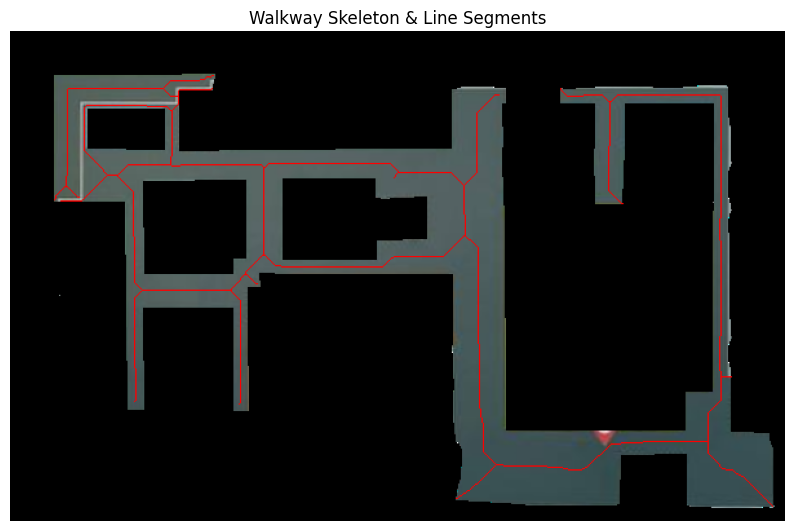

[{'x': 232, 'y': 32}, {'y': 32, 'x': 33}, {'x': 33, 'y': 215}, {'y': 215, 'x': 6}, {'x': 6, 'y': 4}, {'x': 232, 'y': 5}]
[{'x': 119, 'y': 91}, {'x': 119, 'y': 60}, {'y': 60, 'x': 60}, {'y': 91, 'x': 60}]
[{'x': 39, 'y': 132}, {'y': 132, 'x': 88}, {'x': 88, 'y': 295}, {'x': 39, 'y': 295}]
[{'x': 160, 'y': 46}, {'y': 46, 'x': 131}, {'x': 131, 'y': 92}, {'x': 160, 'y': 92}]
[{'x': 103, 'y': 214}, {'y': 214, 'x': 172}, {'x': 172, 'y': 294}, {'x': 103, 'y': 294}]
[{'x': 182, 'y': 115}, {'x': 182, 'y': 175}, {'y': 175, 'x': 172}, {'x': 172, 'y': 187}, {'y': 187, 'x': 104}, {'y': 115, 'x': 103}]
[{'x': 211, 'y': 114}, {'y': 114, 'x': 282}, {'x': 282, 'y': 176}, {'x': 211, 'y': 176}]
[{'x': 162, 'y': 42}, {'y': 42, 'x': 341}, {'x': 341, 'y': 90}, {'x': 162, 'y': 91}]
[{'x': 322, 'y': 128}, {'x': 322, 'y': 160}, {'y': 160, 'x': 284}, {'y': 128, 'x': 284}]
[{'x': 342, 'y': 188}, {'x': 342, 'y': 242}, {'y': 242, 'x': 272}, {'x': 272, 'y': 294}, {'y': 294, 'x': 185}, {'x': 185, 'y': 222}, {'y': 22

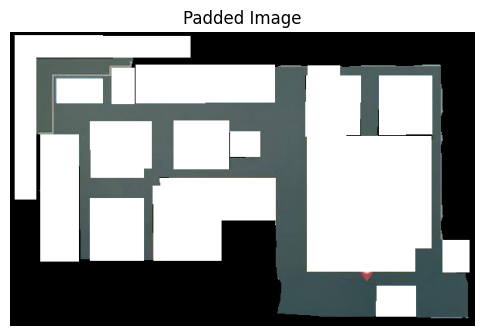


--- Image 1 ---


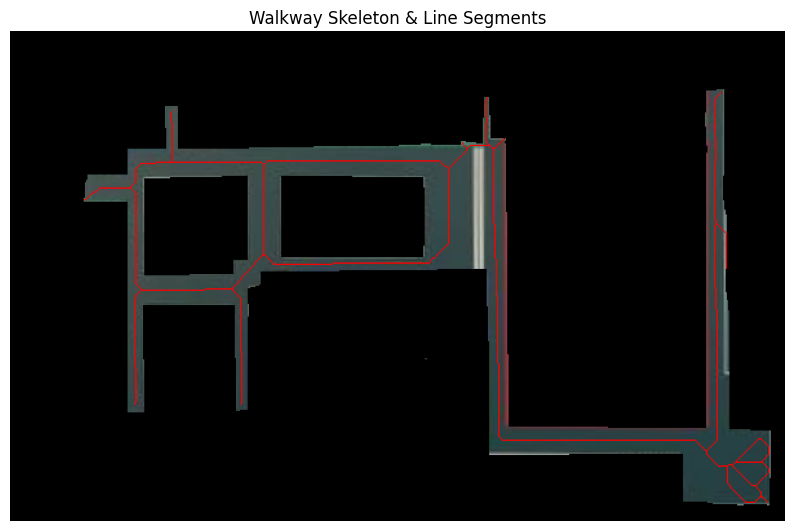

[{'x': 520, 'y': 327}, {'y': 327, 'x': 344}, {'x': 344, 'y': 364}, {'x': 520, 'y': 364}]
[{'x': 557, 'y': 307}, {'y': 307, 'x': 588}, {'x': 588, 'y': 266}, {'x': 557, 'y': 266}]
[{'x': 370, 'y': 240}, {'y': 240, 'x': 343}, {'x': 343, 'y': 326}, {'x': 370, 'y': 325}]
[{'x': 368, 'y': 184}, {'y': 184, 'x': 216}, {'x': 216, 'y': 221}, {'y': 221, 'x': 184}, {'x': 184, 'y': 294}, {'y': 294, 'x': 272}, {'x': 272, 'y': 241}, {'x': 368, 'y': 240}]
[{'x': 194, 'y': 196}, {'x': 194, 'y': 186}, {'y': 186, 'x': 216}, {'x': 216, 'y': 221}, {'y': 221, 'x': 185}, {'y': 196, 'x': 184}]
[{'x': 173, 'y': 212}, {'y': 212, 'x': 103}, {'x': 103, 'y': 294}, {'x': 173, 'y': 292}]
[{'x': 90, 'y': 225}, {'y': 225, 'x': 40}, {'x': 40, 'y': 295}, {'x': 90, 'y': 294}]
[{'x': 90, 'y': 224}, {'y': 224, 'x': 42}, {'x': 42, 'y': 153}, {'x': 90, 'y': 153}]
[{'x': 90, 'y': 153}, {'x': 90, 'y': 132}, {'y': 132, 'x': 40}, {'y': 153, 'x': 41}]
[{'x': 90, 'y': 110}, {'x': 90, 'y': 90}, {'y': 90, 'x': 120}, {'x': 120, 'y': 

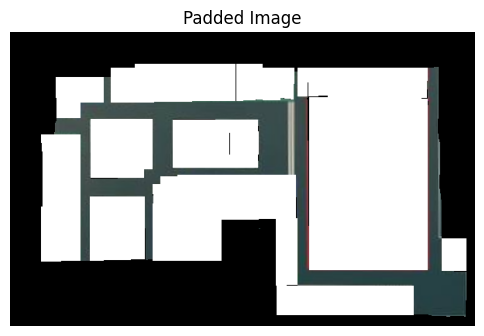


--- Image 2 ---


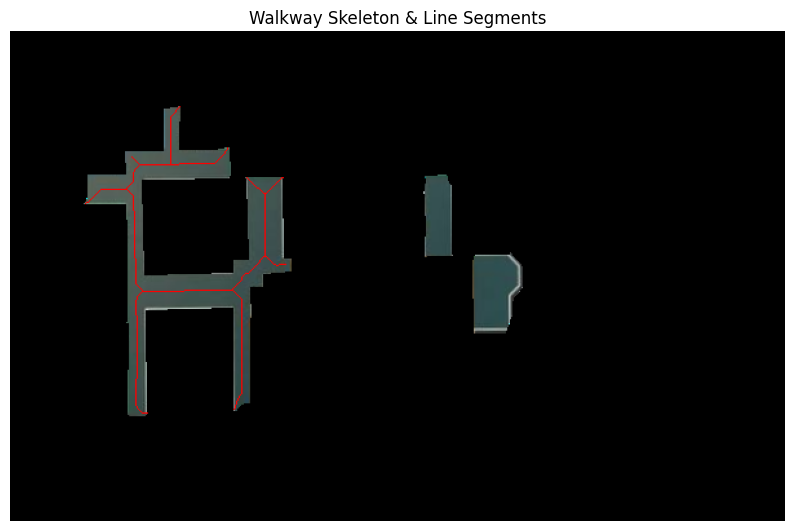

[{'x': 274, 'y': 294}, {'x': 274, 'y': 240}, {'y': 240, 'x': 358}, {'x': 358, 'y': 174}, {'y': 174, 'x': 218}, {'x': 218, 'y': 222}, {'y': 222, 'x': 186}, {'y': 294, 'x': 186}]
[{'x': 218, 'y': 186}, {'x': 218, 'y': 222}, {'y': 222, 'x': 187}, {'x': 187, 'y': 198}, {'y': 198, 'x': 196}, {'y': 186, 'x': 196}]
[{'x': 172, 'y': 214}, {'x': 172, 'y': 294}, {'y': 294, 'x': 106}, {'y': 214, 'x': 105}]
[{'x': 172, 'y': 186}, {'x': 172, 'y': 176}, {'y': 176, 'x': 184}, {'x': 184, 'y': 114}, {'y': 114, 'x': 102}, {'y': 186, 'x': 104}]
[{'x': 211, 'y': 114}, {'y': 114, 'x': 321}, {'x': 321, 'y': 127}, {'y': 127, 'x': 284}, {'x': 284, 'y': 158}, {'y': 158, 'x': 320}, {'x': 320, 'y': 173}, {'x': 211, 'y': 175}]
[{'x': 320, 'y': 126}, {'y': 126, 'x': 283}, {'x': 283, 'y': 158}, {'x': 320, 'y': 158}]
[{'x': 342, 'y': 112}, {'y': 112, 'x': 385}, {'x': 385, 'y': 172}, {'x': 342, 'y': 172}]
[{'x': 91, 'y': 226}, {'y': 226, 'x': 39}, {'x': 39, 'y': 297}, {'x': 91, 'y': 298}]
[{'x': 90, 'y': 224}, {'x': 

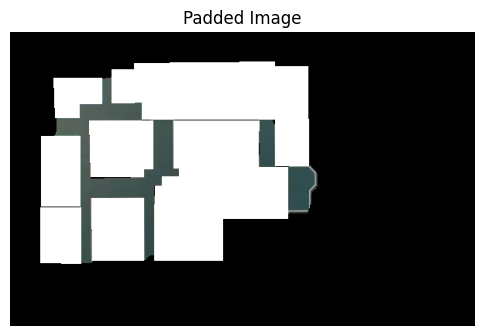


--- Image 3 ---


C:\Users\yongl\AppData\Local\Temp\ipykernel_22108\876039396.py:38: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  pruned = remove_small_objects(labeled, min_size=200)


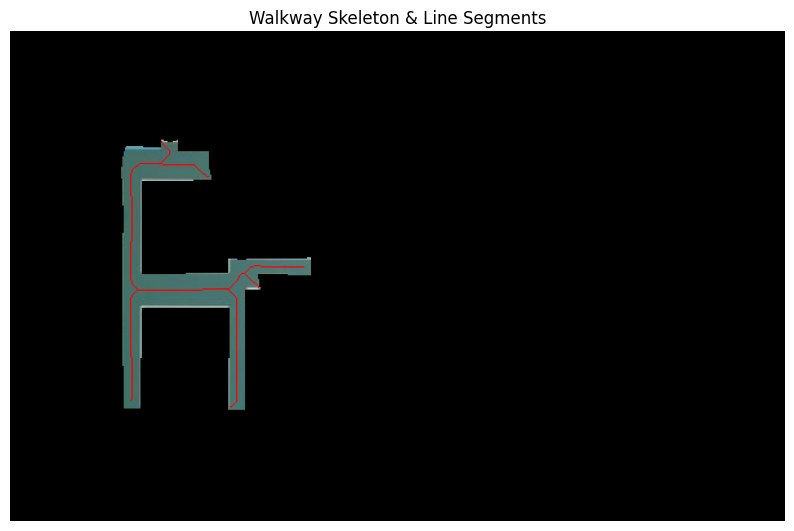

[{'x': 192, 'y': 188}, {'y': 188, 'x': 214}, {'x': 214, 'y': 220}, {'y': 220, 'x': 182}, {'x': 182, 'y': 200}, {'x': 192, 'y': 200}]
[{'x': 215, 'y': 189}, {'y': 189, 'x': 234}, {'x': 234, 'y': 294}, {'y': 294, 'x': 182}, {'x': 182, 'y': 221}, {'x': 215, 'y': 220}]
[{'x': 169, 'y': 214}, {'y': 214, 'x': 102}, {'x': 102, 'y': 292}, {'x': 169, 'y': 292}]
[{'x': 86, 'y': 224}, {'y': 224, 'x': 38}, {'x': 38, 'y': 292}, {'x': 86, 'y': 292}]
[{'x': 86, 'y': 224}, {'y': 224, 'x': 38}, {'x': 38, 'y': 156}, {'x': 86, 'y': 156}]
[{'x': 87, 'y': 155}, {'x': 87, 'y': 114}, {'y': 114, 'x': 55}, {'x': 55, 'y': 130}, {'y': 130, 'x': 36}, {'y': 155, 'x': 37}]
[{'x': 85, 'y': 112}, {'y': 112, 'x': 54}, {'x': 54, 'y': 97}, {'x': 85, 'y': 98}]
[{'x': 86, 'y': 98}, {'y': 98, 'x': 55}, {'x': 55, 'y': 60}, {'y': 60, 'x': 117}, {'x': 117, 'y': 89}, {'x': 86, 'y': 88}]
[{'x': 130, 'y': 92}, {'y': 92, 'x': 160}, {'x': 160, 'y': 48}, {'x': 130, 'y': 49}]
[{'x': 102, 'y': 116}, {'x': 102, 'y': 187}, {'y': 187, '

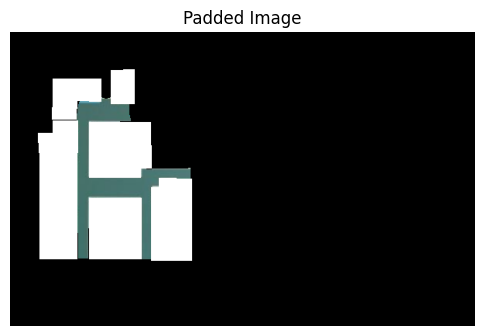

In [ ]:
import json
import cv2
import numpy as np
import base64
from matplotlib import pyplot as plt
from skimage.morphology import skeletonize, remove_small_objects
from skimage.measure import label

# === BASE64 IMAGE DECODING ===
def base64_to_image(base64_string):
    if base64_string.startswith("data:image"):
        base64_string = base64_string.split(",")[1]
    image_bytes = base64.b64decode(base64_string)
    np_arr = np.frombuffer(image_bytes, np.uint8)
    return cv2.imdecode(np_arr, cv2.IMREAD_COLOR)

# === NEIGHBOR DETECTION FOR BRANCH FILTERING ===
def get_neighbors(y, x, skeleton):
    neighbors = []
    for j in range(-1, 2):
        for i in range(-1, 2):
            if j == 0 and i == 0:
                continue
            ny, nx = y + j, x + i
            if 0 <= ny < skeleton.shape[0] and 0 <= nx < skeleton.shape[1]:
                if skeleton[ny, nx] > 0:
                    neighbors.append((ny, nx))
    return neighbors

# === SKELETONIZE AND EXTRACT LINE SEGMENTS ===
def extract_lines_start_end(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = cv2.inRange(gray, 50, 150)  # Threshold grey walkways

    # Skeletonization + branch pruning
    skeleton = skeletonize(mask > 0)
    labeled = label(skeleton)
    pruned = remove_small_objects(labeled, min_size=200)
    skeleton_pruned = pruned > 0

    start_end_points = []

    for region_label in np.unique(pruned):
        if region_label == 0:
            continue
        region_mask = (pruned == region_label)
        coords = np.column_stack(np.where(region_mask))

        endpoints = []
        for y, x in coords:
            if len(get_neighbors(y, x, region_mask)) == 1:
                endpoints.append((x, y))  # (x, y) format

        if len(endpoints) == 2:
            start_end_points.append((endpoints[0], endpoints[1]))

    return skeleton_pruned.astype(np.uint8), start_end_points

# === PLOTTING FUNCTION (INLINE) ===
def plot_overlay_with_lines(image, skeleton, lines, title="Overlay"):
    overlay = image.copy()
    overlay[skeleton == 1] = [0, 0, 255]  # Red skeleton lines

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    for (start, end) in lines:
        plt.plot(start[0], start[1], 'go')  # Start (green)
        plt.plot(end[0], end[1], 'ro')      # End (red)
        plt.plot([start[0], end[0]], [start[1], end[1]], 'y-', linewidth=1)
    plt.title(title)
    plt.axis('off')
    plt.show()

# === PROCESS ONE IMAGE ===
def process_image(base64_image):
    image = base64_to_image(base64_image)
    skeleton, line_segments = extract_lines_start_end(image)
    plot_overlay_with_lines(image, skeleton, line_segments, title="Walkway Skeleton & Line Segments")
    return line_segments

def checkHorizontal(referencePoint, point):
    xRef, yRef = referencePoint['x'], referencePoint['y']
    x,y = point['x'], point['y']
    if abs(xRef - x) > abs(yRef - y):
        return True
    else:
        return False
        
# === PROCESS POINTS TO STRAIGHTEN ===
def process_points(points_dict):
    refinedPoints = []
    for index, point in enumerate(points_dict):
        if index == 0:
            refinedPoints.append(point)
        else:
            referencePoint = refinedPoints[-1]
            if (index == len(points_dict) - 1):
                referencePoint = refinedPoints[0]
            if (checkHorizontal(referencePoint, point)):
                newPoint = {}
                newPoint['y'] = referencePoint['y']
                newPoint['x'] = point['x']
                refinedPoints.append(newPoint)
            else:
                newPoint = {}
                newPoint['x'] = referencePoint['x']
                newPoint['y'] = point['y']
                refinedPoints.append(newPoint)

    return refinedPoints

            


# === MAIN LOOP ===
with open("data.json") as f:
    data = json.load(f)
    allRegions = data.get("drawnRegions", {})
    shapes = data.get("shapeLabels", {})
    walkways = data.get("walkways", [])
    paddedImages = data.get("paddedImages", [])

    for index, base64_img in enumerate(walkways):
        print(f"\n--- Image {index} ---")

        # Process and plot the walkway
        lineSegments = process_image(base64_img)

        # Also show base padded image (if needed)
        # base_img = base64_to_image(paddedImages[index])
        # plt.figure(figsize=(6, 6))
        # plt.imshow(cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB))
        # plt.title("Padded Image")
        # plt.axis("off")
        # plt.show()

        # Optional: print regions and types
        walkwayImage = base64_to_image(base64_img)
        # plt.figure(figsize=(6, 6))
        # plt.imshow(cv2.cvtColor(walkwayImage, cv2.COLOR_BGR2RGB))
        # plt.title("Padded Image")
        # plt.axis("off")
        # plt.show()

        regions = allRegions.get(str(index), [])
        shape = shapes.get(str(index), {})
        for ridx, region in enumerate(regions):
            # print(f"Region {ridx}: {region}")
            # regionType = shape.get(str(ridx), -1)
            # print(f"  -> Type: {regionType}")
            tunedPoints = process_points(region)
            # print(tunedPoints)
            pts = np.array([[int(pt['x']), int(pt['y'])] for pt in tunedPoints], dtype=np.int32)
            pts = pts.reshape((-1, 1, 2))
            # print(pts)
            cv2.fillPoly(walkwayImage, [pts], (255, 255, 255))

        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(walkwayImage, cv2.COLOR_BGR2RGB))
        plt.title("Padded Image")
        plt.axis("off")
        plt.show()


### Making Walls